In [83]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from models_cifar100.resnet import ResNet18
# perform pruning on the model
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import torch.nn as nn

2. [Learning both Weights and Connections for Efficient Neural Networks](https://arxiv.org/abs/1506.02626) :  apply a retrain after the first global pruning

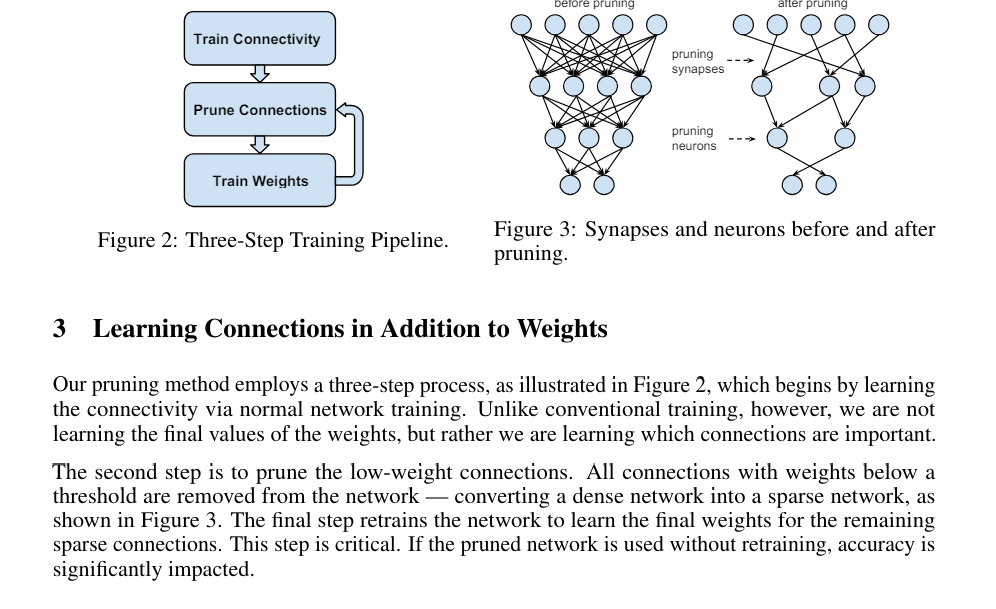

1. train the network to learn which connections are important.
2. we prune the unimportant connections. 
3. retrain the network to fine tune the weights of the remaining connections. 

# Global pruning

In [71]:
# device check
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

CUDA is available. Using GPU.


In [72]:
# We load the dictionary
path1 = 'Session2_lab1_Resnet18_cifar10_binnary_tunning_2.pth'
# loaded_cpt = torch.load(path1)
loaded_cpt = torch.load(path1, map_location=device)
# Fetch the hyperparam value
# hparam_bestvalue = loaded_cpt['hyperparam']
# print('hparam_bestvalue:', hparam_bestvalue)
# accuracy
print("best_test_accuracy",loaded_cpt['final_test_accuracy'])

best_test_accuracy 88.51


In [120]:
# construct the model
model_1 = ResNet18()

# Load the model state dictionary with the loaded state dict
model_1.load_state_dict(loaded_cpt['net'])

# If you use this model for inference (= no further training), you need to set it into eval mode
model_1.eval().to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

# perform global pruning

In [121]:
parameters_to_prune = [
    (module, 'weight') for module in model_1.modules() if isinstance(module, nn.Conv2d)
]

# Prune the model
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.5,
)

# save the pruned model
torch.save({
    'model_state_dict': model_1.state_dict(),
    'pruning_config': {'method': prune.l1_unstructured, 'amount': 0.5}
}, 'globale_pruned_0.5.pth')

In [122]:
# check the sparsity induced in every pruned parameter
for layer, _ in parameters_to_prune:
    print(
        "Sparsity in {}: {:.2f}%".format(
            layer, 100. * float(torch.sum(layer.weight == 0))
            / float(layer.weight.nelement())
        )
    )

Sparsity in Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 50.46%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 49.89%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 48.55%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 48.67%
Sparsity in Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 48.46%
Sparsity in Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False): 48.50%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 48.04%
Sparsity in Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False): 48.29%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 48.10%
Sparsity in Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False): 48.02%
Sparsity in Conv2d(128, 256, 

In [123]:
# check Global sparsity
all_weights = torch.cat([layer.weight.flatten() for layer, _ in parameters_to_prune])
print(
    "Global sparsity: {:.2f}%".format(
        100. * float(torch.sum(all_weights == 0))
        / float(all_weights.nelement())
    )
)

Global sparsity: 50.00%


# evaluate the performance of pruned model 1

In [124]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from models_cifar100.resnet import ResNet18


# Load the CIFAR-10 dataset
## Normalization adapted for CIFAR10
normalize_scratch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# Transforms is a list of transformations applied on the 'raw' dataset before the data is fed to the network. 
# Here, Data augmentation (RandomCrop and Horizontal Flip) are applied to each batch, differently at each epoch, on the training set data only
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_scratch,
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_scratch,
])
### The data from CIFAR10 will be downloaded in the following folder
rootdir = './data/cifar10'
# Load the CIFAR-10 dataset
c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)
c10test = CIFAR10(rootdir,train=False,download=True,transform=transform_test)
# Create DataLoaders
trainloader = DataLoader(c10train,batch_size=32,shuffle=True)
testloader = DataLoader(c10test,batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


Reload the Pruned Model Correctly
- Reinitialize or recreate the model architecture.
- Reapply the pruning to the model exactly as you did before saving.
- Load the pruned state dictionary.

In [127]:
# Load model with metadata
checkpoint = torch.load('globale_pruned_0.5.pth')
model_pruned = ResNet18()  
for module in model_pruned.modules():
    if isinstance(module, nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.5)
model_pruned.load_state_dict(checkpoint['model_state_dict'])
model_pruned.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [128]:
# test the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_pruned(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 16.65%


In [107]:
# cout the number of parameters
total_params = sum(p.numel() for p in model_pruned.parameters())
print(f'Total parameters: {total_params}')

Total parameters: 11220132


# Model Inference Time
The time it takes for the model to make predictions can also be a measure of its complexity, particularly from an operational standpoint.

In [111]:
import time

def measure_inference_time(model, data_loader, device):
    model.eval()
    model.to(device)
    start_time = time.time()
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            outputs = model(data)
    end_time = time.time()
    return end_time - start_time


In [129]:
# Measure inference time
inference_time = measure_inference_time(model_pruned, testloader, device)

In [130]:
inference_time

3.2606606483459473

# fin tunning the hyperparemeter after quantination 

several strategies to recover the accuracy:

Fine-Tuning: After applying binary quantization, you can fine-tune the quantized model on the training dataset. Even a few epochs of fine-tuning might help in recovering some of the lost accuracy.

Hybrid Approaches: Instead of quantizing all layers to binary weights, you might consider a hybrid approach where only certain layers are quantized, or different quantization schemes (like ternary weights or lower-bit quantizations) are applied selectively.

Quantization-Aware Training: Instead of applying quantization as a post-processing step, you can train the network with quantization in mind. 

In [ ]:
# fine-tune a binary quantized model in PyTorch
model_2.train()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)  # Using a lower learning rate for fine-tuning
criterion = nn.CrossEntropyLoss()

num_fine_tune_epochs = 50
# Fine-tuning loop

# train loop
for epoch in range(num_fine_tune_epochs):
    for data, target in trainloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_2(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch}: Loss {loss.item()}')

print('Finished fine-tuning')

# save the model 
torch.save({
    'net': model_2.state_dict(),
    'final_test_accuracy': test_accuracy,
    'hyperparam': hparam_bestvalue,
}, 'Session2_lab1_Resnet18_cifar10_binnary_tunning_2.pth')
print('Model saved')

Epoch 0: Loss 0.04206761345267296
Epoch 1: Loss 0.2428952157497406
Epoch 2: Loss 0.004120262339711189
Epoch 3: Loss 0.0010275698732584715
Epoch 4: Loss 0.00659582344815135
Epoch 5: Loss 0.0070841507986187935
Epoch 6: Loss 0.08025392144918442
Epoch 7: Loss 0.018089229241013527
Epoch 8: Loss 0.045258451253175735
Epoch 9: Loss 0.025238467380404472
Epoch 10: Loss 0.053677886724472046
Epoch 11: Loss 0.0006212434382177889
Epoch 12: Loss 0.006726369261741638
Epoch 13: Loss 0.004015504848212004
Epoch 14: Loss 0.2850176692008972
Epoch 15: Loss 0.001490758964791894
Epoch 16: Loss 0.0038603274151682854
Epoch 17: Loss 0.14339271187782288
Epoch 18: Loss 0.13537806272506714
Epoch 19: Loss 0.002384340390563011
Epoch 20: Loss 0.007040188182145357
Epoch 21: Loss 0.1538671851158142
Epoch 22: Loss 0.01756676286458969
Epoch 23: Loss 0.04192166030406952
Epoch 24: Loss 0.004998200573027134
Epoch 25: Loss 0.007983146235346794
Epoch 26: Loss 0.017243223264813423
Epoch 27: Loss 0.0010289873462170362
Epoch 28: 

In [ ]:
# load the model
path3 = 'Session2_lab1_Resnet18_cifar10_binnary_tunning_2.pth'
loaded_cpt = torch.load(path3)

# construct the model
model_3 = ResNet18()
# Load the model state dictionary with the loaded state dict
model_3.load_state_dict(loaded_cpt['net'])
model_3.eval().to(device)

# test the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

NameError: name 'testloader' is not defined

In [ ]:
inference_time_quantized = measure_inference_time(model_3, testloader, device )
print(f"Quantized Model after tunning Inference Time: {inference_time_quantized:.2f} s")

Quantized Model after tunning Inference Time: 2.38 s


In [ ]:
tuned_quantized_params = count_parameters(model_3)
print(f'Tunned quantized model parameters: {tuned_quantized_params}')


Tunned quantized model parameters: 11220132


In [ ]:
# save the model 
torch.save({
    'net': model_2.state_dict(),
    'final_test_accuracy': test_accuracy,
    'hyperparam': hparam_bestvalue,
}, 'Session2_lab1_Resnet18_cifar10_binnary_tunning_1.pth')

# test the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 88.51%


In [ ]:
path4 = "Session2_lab1_Resnet18_cifar10_binnary_tunning_1.pth"
import os

original = path1
quantized = path2
tuned_quantized_10= path4
tuned_quantized_50 = path3

# Function to convert bytes to megabytes
def bytes_to_mb(size_in_bytes):
    return size_in_bytes / 1024 / 1024

# Measure the file sizes
original_size = os.path.getsize(original)
quantized_size = os.path.getsize(quantized)
tuned_quantized_10_size = os.path.getsize(tuned_quantized_10)
tuned_quantized_50_size = os.path.getsize(tuned_quantized_50)

print(f"Original model size: {bytes_to_mb(original_size):.2f} MB")
print(f"Quantized model size: {bytes_to_mb(quantized_size):.2f} MB")
print(f"Tuned quantized model (10 epochs) size: {bytes_to_mb(tuned_quantized_10_size):.2f} MB")
print(f"Tuned quantized model (50 epochs) size: {bytes_to_mb(tuned_quantized_50_size):.2f} MB")


Original model size: 42.88 MB
Quantized model size: 42.88 MB
Tuned quantized model (10 epochs) size: 42.88 MB
Tuned quantized model (50 epochs) size: 42.88 MB
